In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter
from random import shuffle

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-09-03 08:25:44.186835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 08:25:44.636977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-09-03 08:25:45.613247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-03 08:25:45.631804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-03 08:25:45.632120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Dataset

In [2]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [3]:
IMAGE_SIZE = [64,64]

images=[]
for i,file in enumerate(tqdm(allFiles)):
    with Image.open(file) as im:
        # (width, height) = (im.width // 4, im.height // 4)
        im_resized = im.resize((IMAGE_SIZE[0], IMAGE_SIZE[1]))
        images.append(np.array(im_resized))

  0%|          | 0/1884 [00:00<?, ?it/s]

In [4]:
T=1000

#linear schedule
# beta = np.linspace(1e-4, 0.015, T)
# alpha = 1-beta
# alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
# alphaBar = np.array(alphaBar)

tValues = np.arange(0,T)

#Cosine schedule
def f(t):
    return np.cos((t/T + 0.008)/(1 + 0.008) * np.pi/2)**2

alphaBar = f(tValues)
alpha = (alphaBar[1:])/(alphaBar[0:-1])
alpha = np.insert(alpha, 0, alphaBar[0])
beta = 1 - alpha




def forwardStep(x0Image,t):
    noise = np.random.normal(0, 1, x0Image.shape)
    noisy = np.sqrt(alphaBar[t])*x0Image + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy


# Make a combination of all images and all possible t values and shuffle them
# trainComb = [el for el in iter.product(np.arange(0,len(images)), tValues)]
# shuffle(trainComb)
# dataSize = len(trainComb)

#This generator provides all the timesteps for all images --> A huge dataset with comparably low variation
# def generator():
#     for fileIdx,tValue in trainComb:
#         # image = tf.io.read_file(file)
#         # image = tf.io.decode_jpeg(image, channels=3)
#         image = tf.convert_to_tensor(images[fileIdx])
#         image = tf.image.random_brightness(image, 0.1)
#         image = tf.image.random_contrast(image, 0.95, 1.05)
#         image = (tf.cast(image, tf.float32) / 127.5) - 1
#         x0 = image.numpy()
#         noise, noisy = forwardStep(x0, tValue)
#         yield noisy, noise, [tValue], x0

# Generator that outputs random time steps per image
# repeats=2
# def generator():
#     for im in images:
#         # image = tf.io.read_file(file)
#         # image = tf.io.decode_jpeg(image, channels=3)
#         # image = tf.convert_to_tensor(im)
#         # image = tf.image.random_brightness(image, 0.1)
#         # image = tf.image.random_contrast(image, 0.95, 1.05)
#         # image = (tf.cast(image, tf.float32) / 127.5) - 1
#         x0 = (im/127.5)-1
#         tValues = np.random.choice(T,repeats, replace=False)
#         for tValue in tValues:
#             tValue = np.random.randint(0,T)
#             noise, noisy = forwardStep(x0, tValue)
#             yield noisy, noise, [tValue], x0

# Generator that outputs nSamplesPerTStep for ever t in (0,T)
samplesPerTStep=10
trainComb = []
for t in range(T):
    randomFiles = np.random.choice(np.arange(0,len(images)), samplesPerTStep, replace=False)
    for randomFile in randomFiles:
        trainComb.append(( randomFile, t))
shuffle(trainComb)
dataSize = len(trainComb)
print(dataSize)

def generator():
    for fileIdx,tValue in trainComb:
        im = images[fileIdx]
        x0 = (im/127.5)-1
        noise, noisy = forwardStep(x0, tValue)
        yield noisy, noise, [tValue], x0

10000


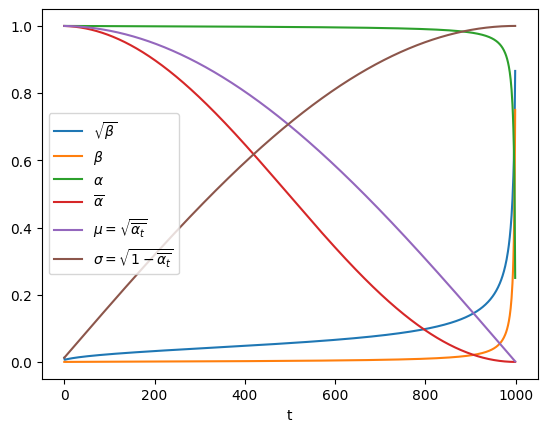

In [5]:
# _ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label=r"$\sqrt{\beta}$")
_ = plt.plot(beta, label=r"$\beta$")
_ = plt.plot(alpha, label=r"$\alpha$")
_ = plt.plot(alphaBar, label=r"$\overline{\alpha}$")
_ = plt.plot(np.sqrt(alphaBar), label=r"$\mu = \sqrt{ \overline{\alpha_t} }$")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label=r"$\sigma = \sqrt{ 1-\overline{\alpha_t} }$")
# _ = plt.plot( (1-alpha)/(np.sqrt(1-np.array(alphaBar)*np.sqrt(alpha))) , label=r"$\frac{1-\alpha}{\sqrt{1-\overline{\alpha}}*\sqrt{\alpha}}}$")
_ = plt.legend()
_ = plt.xlabel("t")

In [6]:
def postprocessImage(im):
    return np.clip(im/2+0.5,0,1)

In [7]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

[158]
(64, 64, 3)
(64, 64, 3)


In [8]:
test = next(g)
np.max(test[1])

4.343145224555205

Text(0.5, 1.0, 'Noise')

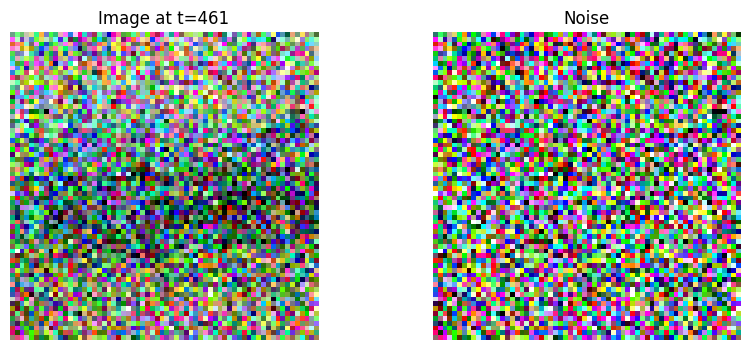

In [9]:
test = next(g)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(test[0]))
plt.axis('off')
plt.title("Image at t="+str(test[2][0]))
plt.subplot(1,2,2)
plt.imshow(postprocessImage(test[1]))
plt.axis('off')
plt.title("Noise")

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

(-0.5, 63.5, 63.5, -0.5)

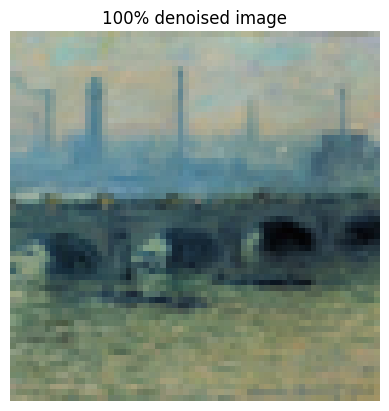

In [10]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2)
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [11]:
noisyImages=[]
noises=[]
x0=images[0]/127.5-1
for tStep in range(T):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

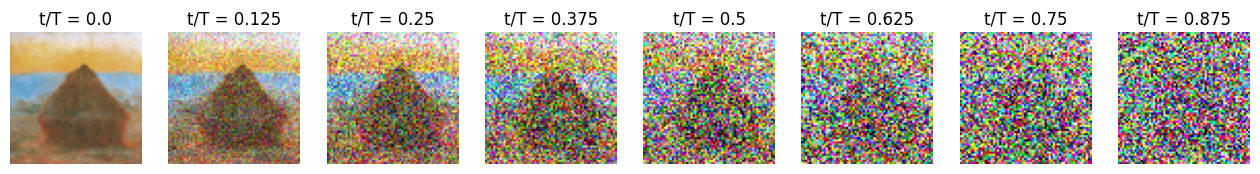

In [12]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(noisyImages[int(i*T/8)]))
    plt.axis("off")
    plt.title("t/T = "+str(i/8))

Backward pass

In [13]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStepTesting(xt, t, predNoise=None, x0Pred=None):

    if x0Pred is None:
        x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t>1:
        randNoise= np.random.normal(0,1,xt.shape)
    else:
        randNoise= np.zeros(xt.shape)
   
    # estimate mean
    meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))
    # compute variance
    betaPred = np.sqrt(beta[t])
    sample = meanPred + betaPred*randNoise
    noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise


variance = np.append(np.array([0]), beta[1:]*(1-alphaBar[0:T-1])/(1-alphaBar[1:T]))
def backwardStep(xt, t, predNoise):
    if t>1:
        randNoise = tf.random.normal(xt.shape)
    else:
        randNoise= tf.zeros(xt.shape)

    # sigPred = np.sqrt(beta)
    # xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred[t]*randNoise

    x0Pred = (1/np.sqrt(alphaBar[t])) * (xt - np.sqrt(1-alphaBar[t]) * predNoise)
    x0Pred = np.clip(x0Pred, -1.0, 1.0)
    meanPred = beta[t] * (np.sqrt(alphaBar[t-1]))/(1-alphaBar[t]) * x0Pred + (1-alphaBar[t-1])*(np.sqrt(alpha[t]))/(1-alphaBar[t]) * xt
    xtPrev = meanPred + np.sqrt(variance[t]) * randNoise

    return xtPrev

def backwardStepDDIM(xt, t, predNoise, sig=0):
    if sig>0:
        if t>1:
            randNoise = tf.random.normal(xt.shape)
        else:
            randNoise= tf.zeros(xt.shape)
    else:
        randNoise=0

    if t==1:
        xtPrev = xt 
    else:
        predX0 = (xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])
        xtPrev = np.sqrt(alphaBar[t-1]) * predX0 + np.sqrt(1-alphaBar[t-1]-sig**2)*predNoise + sig*randNoise

    return xtPrev


for t in np.arange(0,T)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStepTesting(xt, t, predNoise=predNoise)
    # sample, noise = backwardStep(xt, t, x0Pred=noisyImages[0])

    samples.append(sample)
    predNoises.append(noise)

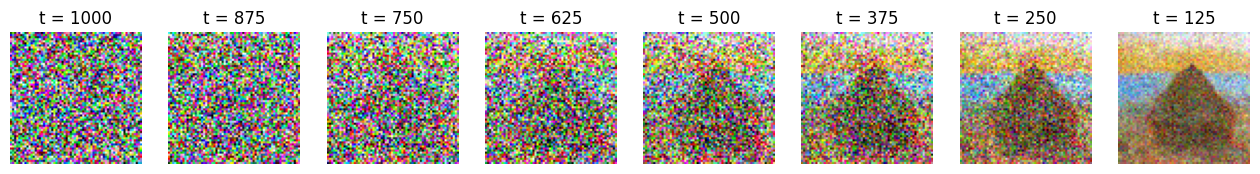

In [14]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(samples[int(i*T/8)]))
    plt.axis("off")
    plt.title("t = "+str(int(T-i*T/8)))

2023-09-03 08:25:52.060065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-03 08:25:52.060504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-03 08:25:52.060850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-03 08:25:52.517470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-03 08:25:52.517817: I tensorflow/compile

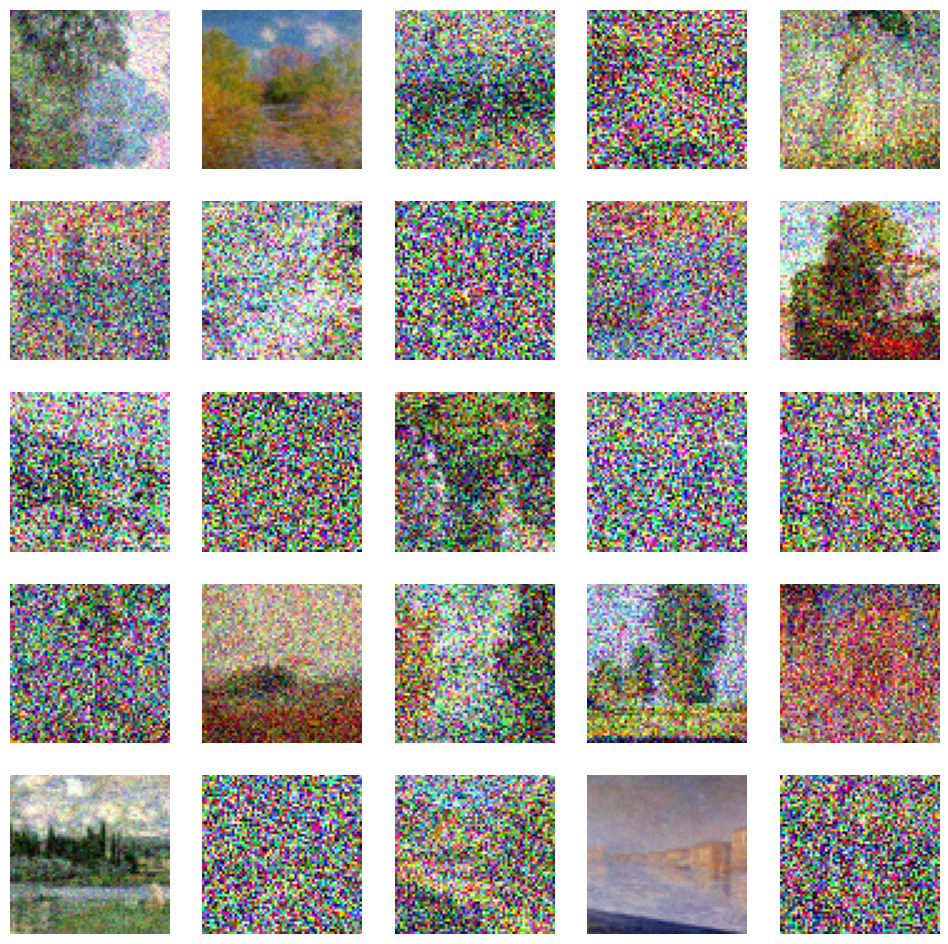

In [15]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(1), dtype=tf.int32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32)))
datasetList = list(dataset.take(25))

plt.figure(figsize=(12,12))
for i in range(5*5):
    plt.subplot(5,5,i+1)
    _ = plt.imshow(np.clip(datasetList[i][0].numpy()/2+0.5, 0,1))
    _ = plt.axis("off")


## Tensorflow

In [16]:
%load_ext tensorboard


In [17]:

def createSimpleUnet(K=1):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    # embeddedStep = tf.keras.layers.Embedding(T, IMAGE_SIZE[0])(stepInput)
    # stepMap = tf.repeat(embeddedStep, IMAGE_SIZE[0], axis=0)
    # stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    # concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown1In = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(inputs)
    xDown1 = tf.keras.layers.BatchNormalization()(xDown1In)
    xDown1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", strides=2, activation="relu")(xDown1)
    xDown1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu"  )(xDown1)
    xDown1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu"  )(xDown1)
    #128
    
    xDown2 = tf.keras.layers.BatchNormalization()(xDown1)
    xDown2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", strides=2, activation="relu")(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xDown2)
    #64

    xDown3 = tf.keras.layers.BatchNormalization()(xDown2)
    xDown3 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xDown3)
    xDown3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", strides=2, activation="relu")(xDown3)
    xDown3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu"  )(xDown3)
    xDown3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu"  )(xDown3)
    #32

    xCenter = tf.keras.layers.BatchNormalization()(xDown3)
    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xCenter)
    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xCenter)
    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xCenter)

    # stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=8, padding="same")(stepMap)
    # concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu")(xCenter)
    #32x32


    xUp3 = tf.keras.layers.BatchNormalization()(xCenter)
    xUp3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu")(xUp3)
    xDown3Concat = tf.keras.layers.Conv2D(K*32, 1, padding="same")(xDown3)
    xConcat3 = tf.keras.layers.Concatenate()([xUp3, xDown3Concat])
    xUp3 = tf.keras.layers.Conv2D(K*64, 3, padding="same", activation="relu" )(xConcat3)
    xUp3 = tf.keras.layers.Conv2DTranspose(K*32, 3, padding="same", strides=2, activation="relu")(xUp3)
    xUp3 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xUp3)
    xUp3 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xUp3)
    #64x64

    xUp2 = tf.keras.layers.BatchNormalization()(xUp3)
    xUp2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu")(xUp2)
    xDown2Concat = tf.keras.layers.Conv2D(K*32, 1, padding="same")(xDown2)
    xConcat2 = tf.keras.layers.Concatenate()([xUp2, xDown2Concat])
    xUp2 = tf.keras.layers.Conv2D(K*32, 3, padding="same", activation="relu" )(xConcat2)
    xUp2 = tf.keras.layers.Conv2DTranspose(K*16, 3, padding="same", strides=2, activation="relu")(xUp2)
    xUp2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xUp2)
    xUp2 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xUp2)
    #128x128

    xUp1 = tf.keras.layers.BatchNormalization()(xUp2)
    xUp1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu")(xUp1)
    xDown1Concat = tf.keras.layers.Conv2D(K*16, 1, padding="same")(xDown1)
    xConcat1 = tf.keras.layers.Concatenate()([xUp1, xDown1Concat])
    xUp1 = tf.keras.layers.Conv2D(K*16, 3, padding="same", activation="relu" )(xConcat1)
    xUp1 = tf.keras.layers.Conv2DTranspose(K*8, 3, padding="same", strides=2, activation="relu")(xUp1)
    xUp1 = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xUp1)
    xUp1 = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xUp1)
    #256x256

    xDown1InConcat = tf.keras.layers.Conv2D(K*8, 1, padding="same")(xDown1In)
    xConcat = tf.keras.layers.Concatenate()([xUp1, xDown1InConcat])
    x = tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu" )(xConcat)
    
    x=tf.keras.layers.Conv2D(K*8, 3, padding="same", activation="relu")(xUp1)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="SimpleUnet")


# model = createSimpleUnet(K=8)

# model.summary()

# dot_img_file = './'+model.name +'.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [18]:
L2=0

def downscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    # xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    xRes = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)
    
    return added


def upscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # xRes = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    # x = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)

    return added


def nonLocalBlock(xIn, ch, filtersize=1):
    theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    out = tf.keras.layers.Attention()([theta, phi, g])
    return tf.math.add(xIn, out)

def resBlock(xIn, ch, filtersize=3):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    xRes = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(xRes)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    return x + xRes


def centerBlock(xIn, stepVector, ch, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    xRes = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = xRes + stepVector

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=4, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = nonLocalBlock(x, ch)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    xRes = tf.keras.layers.Conv2D(ch, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xRes)

    return x + xRes

def get_timestep_embedding(timesteps, embedding_dim):
  half_dim = embedding_dim // 2
  emb = np.log(10000) / (half_dim - 1)
  emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
  emb = tf.cast(timesteps, dtype=tf.float32) * emb[None, :]
  emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
  if embedding_dim % 2 == 1:  # zero pad
    emb = tf.pad(emb, [[0, 0], [0, 1]])
  return tf.cast(emb, tf.float32)




def createUnet(K=2):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    tEmb = get_timestep_embedding(stepInput, K*4)
    tEmb = tf.keras.layers.Dense(K*4)(tEmb)
    tEmb = tf.keras.activations.swish(tEmb)
    tEmb = tf.keras.layers.Dense(K*4)(tEmb)
    tEmb = tf.keras.activations.swish(tEmb)
    # embeddedStep = tf.keras.layers.Embedding(T, IMAGE_SIZE[0])(stepInput)
    # stepMap = tf.repeat(embeddedStep, IMAGE_SIZE[0], axis=0)
    # stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))
    # stepMap = tf.keras.layers.Reshape((*IMAGE_SIZE, 1))(get_timestep_embedding(stepInput, IMAGE_SIZE[0]*IMAGE_SIZE[1]))


    xDown2 = tf.keras.layers.BatchNormalization()(inputs)
    xDown2 = tf.keras.layers.LeakyReLU()(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown2)

    tEmb2 = tf.keras.layers.Dense(K*2)(tEmb)
    tEmb2 = tf.expand_dims(tEmb2,1)
    tEmb2 = tf.expand_dims(tEmb2,1)
    xDown2 = xDown2 + tEmb2

    xDown2 = tf.keras.layers.BatchNormalization()(xDown2)
    xDown2 = tf.keras.layers.LeakyReLU()(xDown2)
    xDown2 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown2)
    
    xDown4 = downscaleBlock(xDown2, K*2, K*2, 3)
    #128
    xDown4 = tf.keras.layers.BatchNormalization()(xDown4)
    xDown4 = tf.keras.layers.LeakyReLU()(xDown4)
    xDown4 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown4)

    tEmb4 = tf.keras.layers.Dense(K*2)(tEmb)
    tEmb4 = tf.expand_dims(tEmb4,1)
    tEmb4 = tf.expand_dims(tEmb4,1)
    xDown4 = xDown4 + tEmb4

    xDown4 = tf.keras.layers.BatchNormalization()(xDown4)
    xDown4 = tf.keras.layers.LeakyReLU()(xDown4)
    xDown4 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown4)

    xDown8 = downscaleBlock(xDown4, K*2, K*4, 3)
    #64
    xDown8 = tf.keras.layers.BatchNormalization()(xDown8)
    xDown8 = tf.keras.layers.LeakyReLU()(xDown8)
    xDown8 = tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown8)

    tEmb8 = tf.keras.layers.Dense(K*4)(tEmb)
    tEmb8 = tf.expand_dims(tEmb8,1)
    tEmb8 = tf.expand_dims(tEmb8,1)
    xDown8 = xDown8 + tEmb8

    xDown8 = tf.keras.layers.BatchNormalization()(xDown8)
    xDown8 = tf.keras.layers.LeakyReLU()(xDown8)
    xDown8 = tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown8)

    xDown16 = downscaleBlock(xDown8, K*4, K*8, 3)
    #32
    xDown16 = tf.keras.layers.BatchNormalization()(xDown16)
    xDown16 = tf.keras.layers.LeakyReLU()(xDown16)
    xDown16 = tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown16)

    tEmb16 = tf.keras.layers.Dense(K*8)(tEmb)
    tEmb16 = tf.expand_dims(tEmb16,1)
    tEmb16 = tf.expand_dims(tEmb16,1)
    xDown16 = xDown16 + tEmb16

    xDown16 = tf.keras.layers.BatchNormalization()(xDown16)
    xDown16 = tf.keras.layers.LeakyReLU()(xDown16)
    xDown16 = tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown16)

    xDown32 = downscaleBlock(xDown16, K*8, K*16, 3)
    #16x16
    xDown32 = tf.keras.layers.BatchNormalization()(xDown32)
    xDown32 = tf.keras.layers.LeakyReLU()(xDown32)
    xDown32 = tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)

    tEmb32 = tf.keras.layers.Dense(K*16)(tEmb)
    tEmb32 = tf.expand_dims(tEmb32,1)
    tEmb32 = tf.expand_dims(tEmb32,1)
    xDown32 = xDown32 + tEmb32

    xDown32 = tf.keras.layers.BatchNormalization()(xDown32)
    xDown32 = tf.keras.layers.LeakyReLU()(xDown32)
    xDown32 = tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)

    xCenter = resBlock(xDown32, K*16)
    xCenter = centerBlock(xCenter, tEmb32, K*16, 3)
    xCenter = resBlock(xCenter, K*16)
    #16x16

    xUp16 = upscaleBlock(xCenter, K*16, K*8, 3)
    #32x32
    xConcat16 = tf.keras.layers.Conv2D(K*8, 1)(xDown16)
    xConcat16 = tf.keras.layers.Concatenate()([xUp16, xConcat16])
    xUp16 = tf.keras.layers.BatchNormalization()(xConcat16)
    xUp16 = tf.keras.layers.LeakyReLU()(xUp16)
    xUp16=tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp16)

    xUp16 = xUp16 + tEmb16

    xUp16 = tf.keras.layers.BatchNormalization()(xUp16)
    xUp16 = tf.keras.layers.LeakyReLU()(xUp16)
    xUp16=tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp16)

    xUp8 = upscaleBlock(xUp16, K*8, K*4, 3)
    #64
    xConcat8 = tf.keras.layers.Conv2D(K*4, 1)(xDown8)
    xConcat8 = tf.keras.layers.Concatenate()([xConcat8, xUp8])
    xUp8 = tf.keras.layers.BatchNormalization()(xConcat8)
    xUp8 = tf.keras.layers.LeakyReLU()(xUp8)
    xUp8=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp8)

    xUp8 = xUp8 + tEmb8

    xUp8 = tf.keras.layers.BatchNormalization()(xUp8)
    xUp8 = tf.keras.layers.LeakyReLU()(xUp8)
    xUp8=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp8)

    xUp4 = upscaleBlock(xUp8, K*4, K*2, 3)
    #128
    xConcat4 = tf.keras.layers.Conv2D(K*2, 1)(xDown4)
    xConcat4 = tf.keras.layers.Concatenate()([xConcat4, xUp4])
    xUp4 = tf.keras.layers.BatchNormalization()(xConcat4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
    xUp4=tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

    xUp4 = xUp4 + tEmb4
    
    xUp4 = tf.keras.layers.BatchNormalization()(xUp4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
    xUp4=tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

    xUp2 = upscaleBlock(xUp4, K*2, K*2, 3)
    #256
    xConcat2 = tf.keras.layers.Conv2D(K*2, 1)(xDown2)
    xConcat2 = tf.keras.layers.Concatenate()([xConcat2, xUp2])
    
    x = tf.keras.layers.BatchNormalization()(xConcat2)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = x + tEmb2

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    outputs = tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet_T{}_K{}".format(T,K))


model = createUnet(K=32)

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


Model: "unet_T1000_K32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 tf.cast (TFOpLambda)        (None, 1)                    0         ['input_2[0][0]']             
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 64)                   0         ['tf.cast[0][0]']             
 da)                                                                                              
                                                                                                  
 tf.math.sin (TFOpLambda)    (None, 64)                   0         ['tf.math.multipl

In [19]:
loadExistingModel=False

if loadExistingModel:
    model = tf.keras.models.load_model(os.path.join(DATA_PATH, "unet_T600_K4epoch_110"))
    startEpoch=111
else:
    startEpoch=0

In [20]:
def saveImages(model, epoch, step, summary_writer=None, maxStep=0):
  initInput = tf.random.normal((3, *IMAGE_SIZE, 3), dtype=tf.float32)
  samples = [initInput]

  for t in np.arange(1,T)[::-1]:
      pred = model((samples[-1], tf.constant([t, t, t])), training=False)
      xt = samples[-1]
      
      # sample, noise = backwardStep(xt, t, x0Pred=predX0)
      sample = backwardStep(xt, t, predNoise=pred)

      samples.append(sample)

  _ = plt.figure(figsize=(12,8))

  sampleIdx = np.linspace(1, T-1, 5)

  for j in range(3):
    for i in range(5):
        _ = plt.subplot(3, 5, j*5+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:])
        if summary_writer is not None:
           with summary_writer.as_default():
              tf.summary.image("Training data", postprocessImage(samples[int(sampleIdx[-1])]), step=maxStep*epoch+step)
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

  plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))

  plt.close()
  minVals=[]
  maxVals=[]
  for s in samples:
      minVals.append(np.min(s))
      maxVals.append(np.max(s))
  plt.plot(minVals)
  _=plt.plot(maxVals)
  plt.savefig(os.path.join(DATA_PATH,"sampleStatsDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
  plt.close()

In [21]:
class MSESSIMLoss(tf.keras.losses.Loss):
    def __init__(self, alpha):
        super().__init__(name="MSE_SSIM_Loss")
        assert(alpha<1.0)
        self.alpha = tf.constant(alpha)
        
    def call(self, yTrue, yPred):
        mse =  tf.math.reduce_mean(tf.math.square(yPred - yTrue))
        ssim = tf.image.ssim(tf.clip_by_value(yPred,-1,1)/2+0.5, tf.clip_by_value(yTrue,-1,1)/2+0.5, max_val=1.0)
        ssimLoss =  1-tf.math.reduce_mean(ssim, axis=-1)
        return (1-self.alpha)*mse + self.alpha*ssimLoss

testLoss = MSESSIMLoss(0.2)
testLoss(tf.ones([1,20,20,3]), tf.ones([1,20,20,3])*0.9)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0084743025>

In [22]:

BATCH_SIZE=64
LOG_INTERVAL=5
SAVE_IMAGE_INTERVAL=10
epochs = 1001
saveModel=False



log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-4)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
# lossFn = tf.keras.losses.KLDivergence()
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = MSESSIMLoss(0.1)

mseMetric = tf.keras.metrics.MeanSquaredError()

# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
# datasetShuffled = dataset.shuffle(200)
batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(noisyImage, noise, t):
    with tf.GradientTape() as tape:
        predicted = model((noisyImage, t), training=True) 

        loss = lossFn(predicted, noise)


    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    mseMetric.update_state(predicted,noise)

    return loss, predicted



maxStep=len(allFiles)*T//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (noisyImage, noise, t, x0) in enumerate(batchedDataset):
        loss, predictedImage = trainStep(noisyImage, noise, t)

        # Log 
        if step % LOG_INTERVAL == 0:
            # ssim = tf.image.ssim(postprocessImage(predictedImage), postprocessImage(noise), max_val=1.0)
            template = 'Epoch {}/Step {}, Loss: {:.4f}'
            print(template.format(epoch, step, mseMetric.result().numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', mseMetric.result().numpy(), step=maxStep*epoch+step)
                # tf.summary.scalar('ssim', tf.math.reduce_mean(ssim), step=maxStep*epoch+step)
                summary_writer.flush()
        
    if epoch % SAVE_IMAGE_INTERVAL==0:
        print("Generate images")
        saveImages(model, epoch, step, summary_writer, maxStep)

    maxStep=step

    mseMetric.reset_state()

    if saveModel:
      model.save(os.path.join(DATA_PATH, model.name+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0


2023-09-03 08:26:10.098537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-03 08:26:11.850273: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-03 08:26:12.705358: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0d036b1ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-03 08:26:12.705397: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-09-03 08:26:12.708745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-03 08:26:12.791710: I ./tensorflow/com

Epoch 0/Step 0, Loss: 1.7933
Epoch 0/Step 5, Loss: 1.2880
Epoch 0/Step 10, Loss: 1.0405
Epoch 0/Step 15, Loss: 0.8892
Epoch 0/Step 20, Loss: 0.7895
Epoch 0/Step 25, Loss: 0.7170
Epoch 0/Step 30, Loss: 0.6616
Epoch 0/Step 35, Loss: 0.6206
Epoch 0/Step 40, Loss: 0.5874
Epoch 0/Step 45, Loss: 0.5561
Epoch 0/Step 50, Loss: 0.5303
Epoch 0/Step 55, Loss: 0.5085
Epoch 0/Step 60, Loss: 0.4912
Epoch 0/Step 65, Loss: 0.4751
Epoch 0/Step 70, Loss: 0.4608
Epoch 0/Step 75, Loss: 0.4487
Epoch 0/Step 80, Loss: 0.4368
Epoch 0/Step 85, Loss: 0.4264
Epoch 0/Step 90, Loss: 0.4174
Epoch 0/Step 95, Loss: 0.4090
Epoch 0/Step 100, Loss: 0.4016
Epoch 0/Step 105, Loss: 0.3942
Epoch 0/Step 110, Loss: 0.3876
Epoch 0/Step 115, Loss: 0.3815
Epoch 0/Step 120, Loss: 0.3758
Epoch 0/Step 125, Loss: 0.3706
Epoch 0/Step 130, Loss: 0.3660
Epoch 0/Step 135, Loss: 0.3610
Epoch 0/Step 140, Loss: 0.3566
Epoch 0/Step 145, Loss: 0.3517
Epoch 0/Step 150, Loss: 0.3479
Epoch 0/Step 155, Loss: 0.3436
Generate images

Start of epoc

KeyboardInterrupt: 

## Testing

In [ ]:
initInput = tf.random.normal((2, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]
S=300
tauValues = np.linspace(1,T-1,S)

for t in tauValues[::-1]:
    t = int(t)
    predNoise = model((samples[-1], tf.constant([t,t])), training=False)
    xt = samples[-1]
    
    sample = backwardStepDDIM(xt, t, predNoise=predNoise)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

sampleIdx = np.linspace(0, S, 5)

for j in range(2):
    for i in range(5):
        _ = plt.subplot(2,5,j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i]*T/S)))

In [ ]:

variance = np.append(np.array([0]), beta[1:]*(1-alphaBar[0:T-1])/(1-alphaBar[1:T]))

def backwardStep(xt, t, predNoise):
    if t>1:
        randNoise = tf.random.normal(xt.shape)
    else:
        randNoise= tf.zeros(xt.shape)

    # compute variance

    # predX0 = (1/np.sqrt(alphaBar[t])) * xt - np.sqrt(1.0-alphaBar[t])/np.sqrt(alphaBar[t]) * predNoise 
    # predX0  = 1/np.sqrt(alpha[t]) * (xt - beta[t]/np.sqrt(1-alphaBar[t]) * predNoise )
    # xtPrev = predX0 * (np.sqrt(alphaBar[t-1])*beta[t]) / ((1-alphaBar[t])) + xt*((1-alphaBar[t-1])*np.sqrt(alpha[t]))/((1-alphaBar[t])) + sigPred[t]*randNoise

    # sigPred = np.sqrt(beta)
    # xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred[t]*randNoise

    x0Pred = (1/np.sqrt(alphaBar[t])) * (xt - np.sqrt(1-alphaBar[t]) * predNoise)
    x0Pred = np.clip(x0Pred, -1.0, 1.0)
    meanPred = beta[t] * (np.sqrt(alphaBar[t-1]))/(1-alphaBar[t]) * x0Pred + (1-alphaBar[t-1])*(np.sqrt(alpha[t]))/(1-alphaBar[t]) * xt
    xtPrev = meanPred + np.sqrt(variance[t]) * randNoise

    return xtPrev, x0Pred



initInput = tf.random.normal((3, *IMAGE_SIZE, 3), dtype=tf.float32) * np.sqrt(1-alphaBar[T-1])
samples = [initInput]
predictedX0s = []
predNoises=[]

for t in tqdm(np.arange(1,T)[::-1]):
    # print(samples[-1])
    pred = model((samples[-1], tf.constant([t, t, t])), training=False)
    xt = samples[-1]
    
    # sample, noise = backwardStep(xt, t, x0Pred=predX0)
    sample, predX0 = backwardStep(xt, t, predNoise=pred)

    samples.append(sample)
    predictedX0s.append(predX0)
    predNoises.append(pred)

_ = plt.figure(figsize=(12,8))

N = 8
sampleIdx = np.linspace(1, T-1, N)

plt.figure(figsize=(8,15))
for j in range(3):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
for j in np.arange(3,6):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(predictedX0s[int(sampleIdx[i])-1])[j-3,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
for j in np.arange(6,9):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(predNoises[int(sampleIdx[i])-1])[j-6,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
plt.tight_layout()

In [ ]:
testT = 800
plt.subplot(1,2,1)
plt.imshow(postprocessImage(samples[testT])[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(postprocessImage(predNoises[testT])[0,:,:,:])
test = samples[0]

test = forwardStep(np.zeros((64,64)),500)[1]
testSamples = [forwardStep(np.zeros((16,16)),t)[1] for t in range(1000)]
print(np.min(test), np.max(test))

plt.figure()
minVals=[]
maxVals=[]
for s in predNoises:
# for s in testSamples:
    minVals.append(np.min(s))
    maxVals.append(np.max(s))
plt.plot(minVals, label="min(predNoises)")
plt.plot(maxVals, label="max(predNoises)")
minVals=[]
maxVals=[]
for s in samples:
    minVals.append(np.min(s))
    maxVals.append(np.max(s))
plt.plot(minVals, label="min(samples)")
plt.plot(maxVals, label="max(samples)")
_ = plt.legend()

In [ ]:
t=999
predX0 = 1/np.sqrt(alpha[t]) * (initInput - beta[t]/np.sqrt(1-alphaBar[t]) * predNoises[0] )
print(np.min(predX0), np.max(predX0))
print(np.min(predX0), np.max(predX0))
print(alphaBar[t])
print(1/np.sqrt(alpha[t]))
print(beta[t]/np.sqrt(1-alphaBar[t])*1/np.sqrt(alpha[t]))

In [ ]:
testIdx = np.random.randint(0,50)
testImage=tf.expand_dims(list(dataset.take(50))[int(testIdx)][0],0)
testT=tf.expand_dims(list(dataset.take(50))[int(testIdx)][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[int(testIdx)][1],0)

print(testT.numpy())
print(np.min(testImage), np.max(testImage))

In [ ]:
predNoise = model((testImage, testT))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(testImage)[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(postprocessImage(predNoise)[0,:,:,:])


In [ ]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+3)/6)
plt.title("Predicted Noise")
plt.subplot(1,3,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+3)/6)
plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow((testNoise.numpy()[0,:,:,:]+3)/6 - (predNoise.numpy()[0,:,:,:]+3)/6)

In [ ]:
t = 20
sigPred = np.sqrt(beta[t])

xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred*randNoise

return xtPrev

In [ ]:
print(np.min(testNoise.numpy()))
print(np.max(testNoise.numpy()))

In [ ]:
testTNum = testT.numpy()[0][0]